### Lending Club - Part 4 - Project Goal 1 - Results

Project Goals:
1. At loan origination: is my model able to predict if a customer will fully pay off their debt or will they incur a charge off
2. Multiclassification exercise: the objective of the second part is to get experience with multiclassification.

In [2]:
result_summary = joblib.load('result_summary.pkl')

In [3]:
result_summary

,model,f1_score_0,f1_score_1,accuracy,macro_avg,weighted_avg
0,logistic_regression,0.428401,0.737777,0.640484,0.583089,0.676129
1,random_forest,0.430754,0.769852,0.672225,0.600303,0.702281
2,AdaBoost,0.174548,0.520444,0.393336,0.347496,0.451518
3,gradientboosting,0.268516,0.844675,0.743761,0.556596,0.729865
4,SVM_20pc_df,0.432493,0.729972,0.634062,0.581233,0.670694
5,knn,0.338297,0.755146,0.642558,0.546722,0.672081
6,ann,0.399663,0.731094,0.628564,0.565379,0.665050
7,gaussian_naive_bayes,0.374116,0.830290,0.732982,0.602203,0.739389


f1 score gives the harmonic mean of the precision and recall. The f1_score of label 0 is of greater interest since this is where people are incurring a charge-off

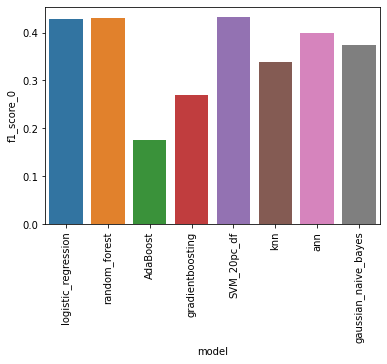

In [8]:
sns.barplot(data=result_summary, x='model', y='f1_score_0')
plt.xticks(rotation=90);

According to the plot above, logistic regression, random forest and SVM with 20 percent of the dataset used for training gives the best f1 score for label 0. These 3 models will be the ones we're interested to see how they perform with regards to their f1 score for label 1 and accuracy.

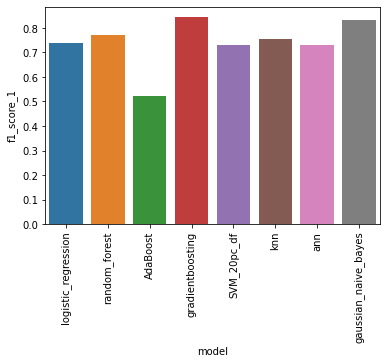

In [5]:
sns.barplot(data=result_summary, x='model', y='f1_score_1')
plt.xticks(rotation=90);

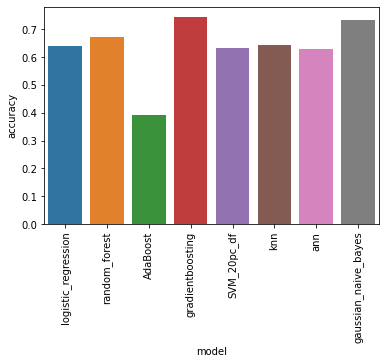

In [6]:
sns.barplot(data=result_summary, x='model', y='accuracy')
plt.xticks(rotation=90);

In [14]:
scores_df = joblib.load('scores_df_final.pkl')

<AxesSubplot:ylabel='cross val - balanced accuracy score'>

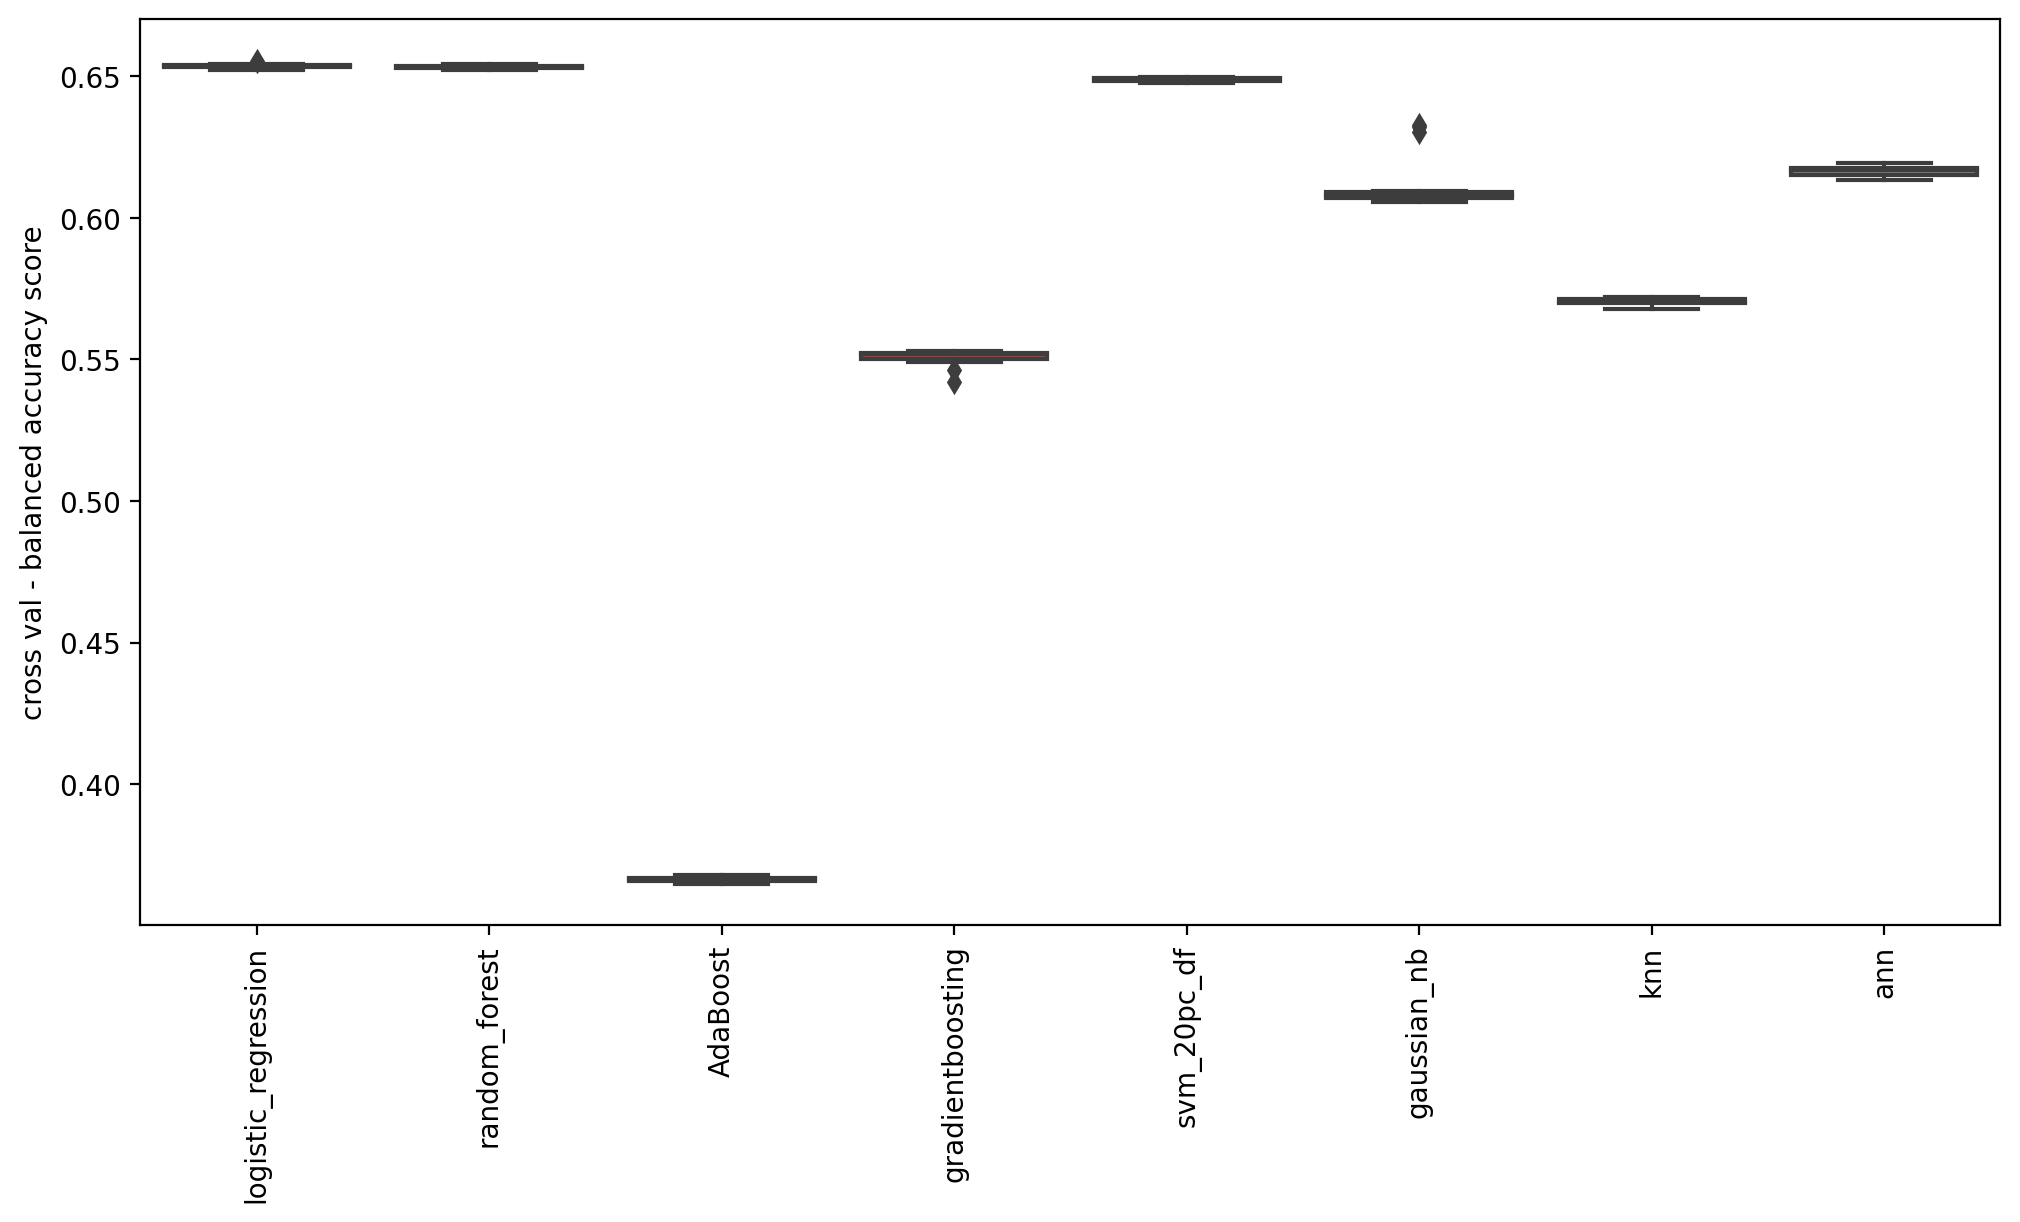

In [18]:
plt.figure(figsize=(12,6), dpi=200)
# plt.ylim(0.6, 0.975)
plt.xticks(rotation=90)
plt.ylabel('cross val - balanced accuracy score')
sns.boxplot(data=scores_df)

<AxesSubplot:ylabel='cross val - balanced accuracy score'>

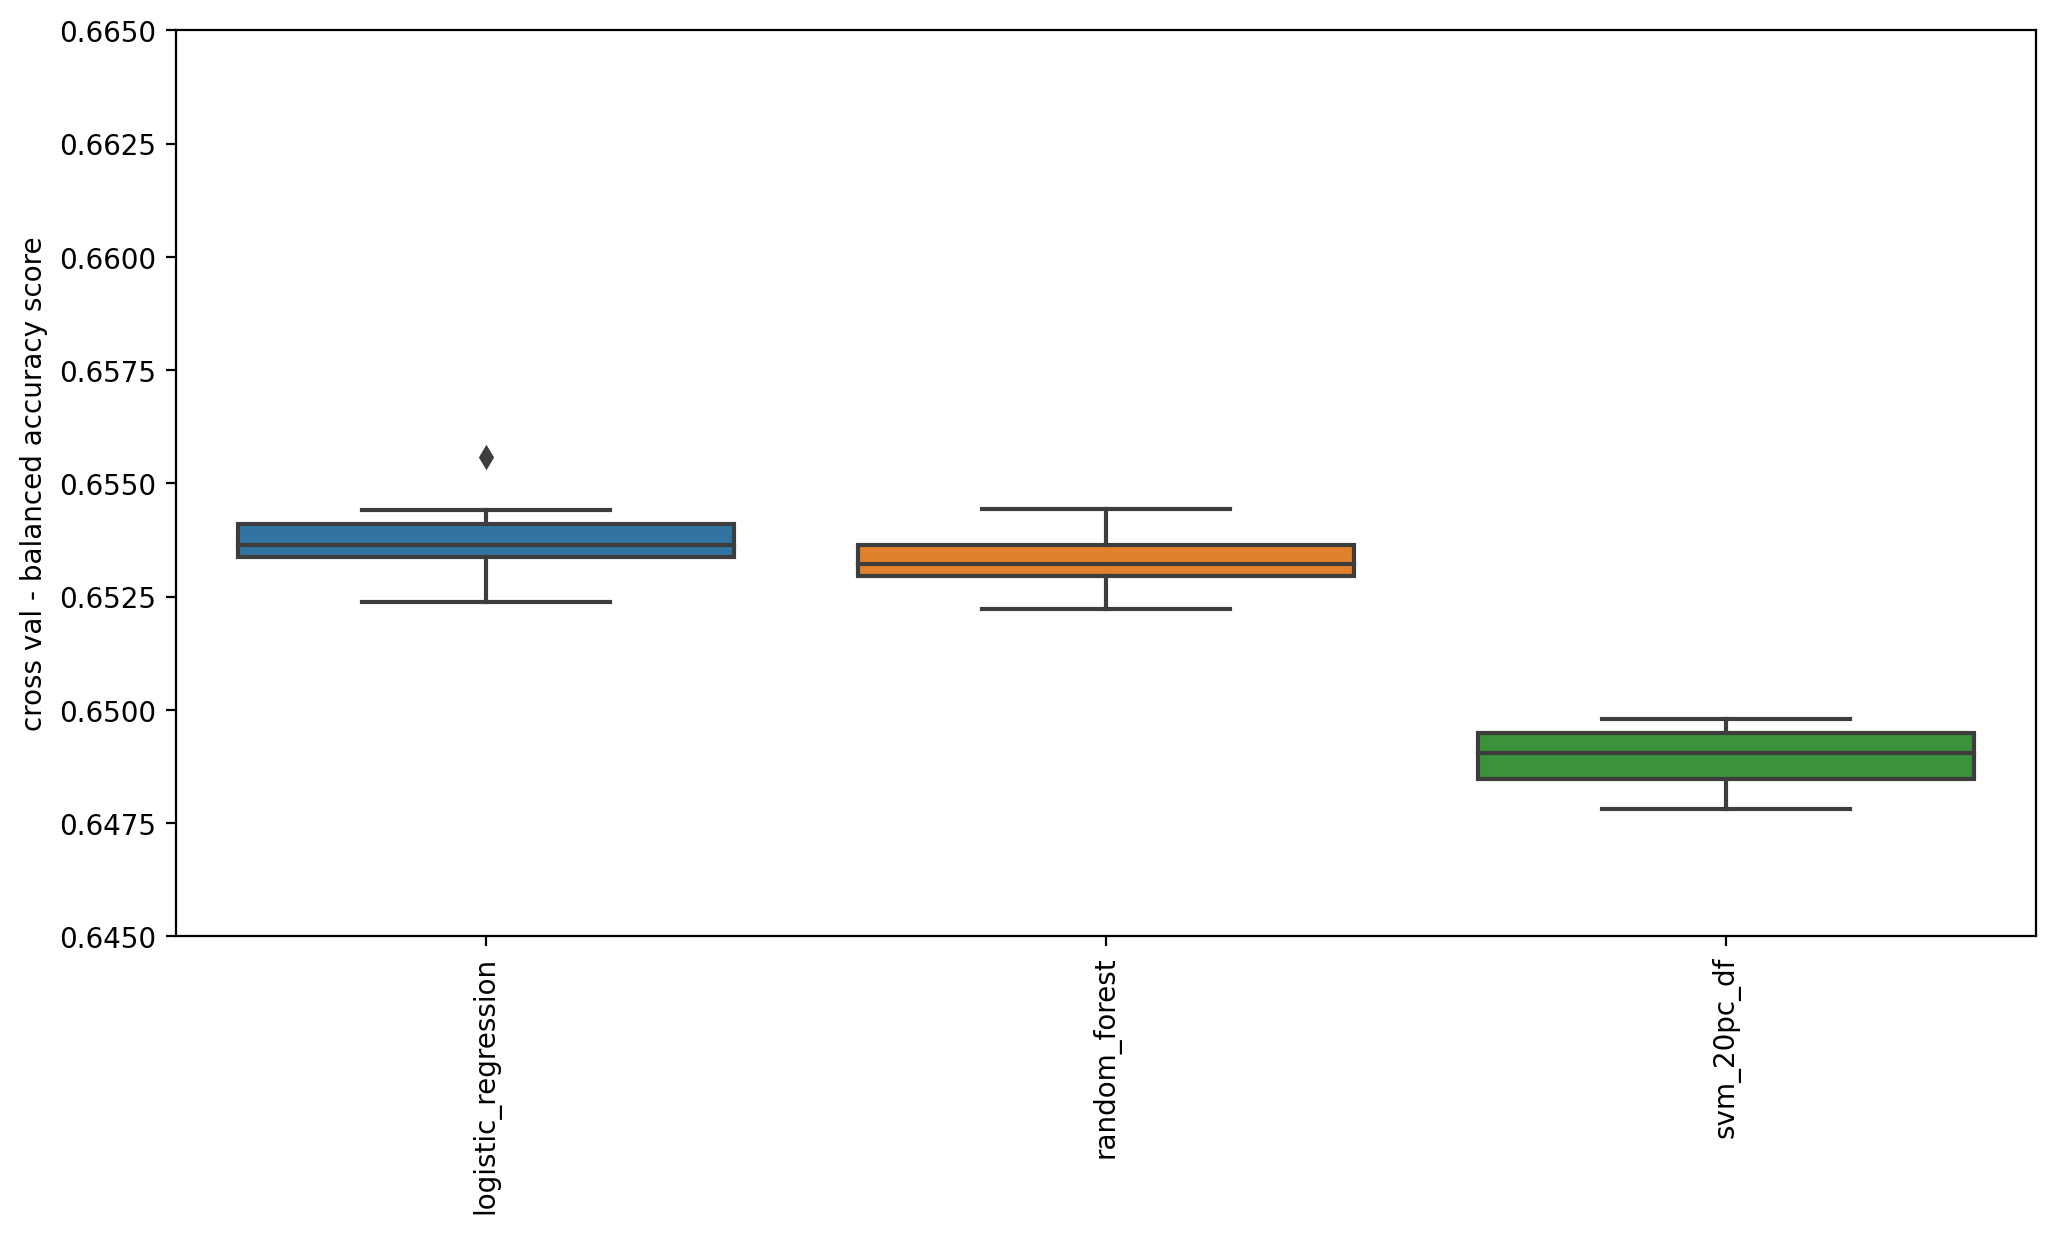

In [19]:
plt.figure(figsize=(12,6), dpi=200)
plt.ylim(0.645, 0.665)
plt.xticks(rotation=90)
plt.ylabel('cross val - balanced accuracy score')
sns.boxplot(data=scores_df[['logistic_regression', 'random_forest', 'svm_20pc_df']])

    model	             f1_score_0	  f1_score_1  accuracy	             
    logistic_regression   0.428401	    0.737777	0.640484	
    random_forest	     0.430754	    0.769852	0.672225
    SVM_20pc_df	       0.432493	    0.729972	0.634062

The f1 scores for logistic regression, random forest and SVM trained with 20 percent of the dataset gives very comparable performance. If we are solely focus on f1 score for label 0, SVM gives the highest performance. However, SVM comes with the downside of heavy computations required to make predictions and in the cv - balanced accuracy score, it performs slightly worst than logistic regression and random_forest. Overall, random forest seem to give slightly better overall results in f1 scores for label 0 and 1 and very comparable cv balanced accuracy score to logistic regression. This is the final model that I will pick. 

I will test the random forest model on the test set. In practice, after I am satisfied with the final result, I should retrain the final model on the entire dataset for deployment but since I am not deploying this model, this part of the project will be concluded.

In [19]:
grid = joblib.load('random_forest.pkl')

              precision    recall  f1-score   support

           0       0.33      0.63      0.43     40348
           1       0.88      0.69      0.77    161159

    accuracy                           0.67    201507
   macro avg       0.61      0.66      0.60    201507
weighted avg       0.77      0.67      0.70    201507



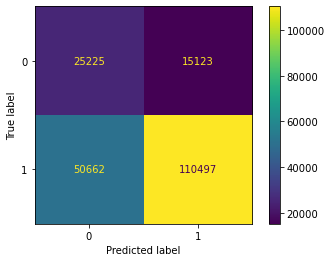

In [20]:
preds = grid.predict(X_test)
plot_confusion_matrix(grid, X_test, y_test)
print(classification_report(y_test, preds))

## Improvement plan and self-evaluation:
1. Going back to the dataset and exploring the feature set in greater detail. Finding or creating new features using domain knowledge from research or through a subject matter expert's experience to expand the feature set.

This concludes goal 1 of my project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

In [3]:
df = pd.read_csv('./lendingclub_processed.csv')

In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df = df.drop(['total_pymnt', 'last_fico_range_high'], axis=1)

In [6]:
index = df[df['loan_status'] == 'Current'].index

In [7]:
df = df.drop(index, axis=0)

In [8]:
df['loan_status'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

In [9]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [11]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)